# Lorenz system

Starting from the data matrix $\mathbf{X}$ we have our approximated differential equation
$$
\mathbf{X'=\Theta(X)\Xi}
$$

To subpackes ```pysindy.differentiation```, ```pysindy.feature_library``` and ```pysindy.optimizers``` are used to "calculate" $\mathbf{X'}$, $\mathbf{\Theta}$ and $\mathbf{\Xi}$ respectively.

The Lorenz system used in paper has parameters $\sigma=10, \beta=\frac83,\rho=28$ and initial condition $(x(0),\ y(0),\ z(0))^T=(-8,\ 7,\ 27)^T$. So the system is 

$$
\begin{cases}
    x'=10(y-x)\\
    y'=x(28-z)-y\\
    z'=xy-\frac83 z
\end{cases}
$$

The time interval is $t\in[0,100]$ with time-step $\Delta t = 0.001$.

## Data Generation

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import pysindy as ps
from pysindy.utils import lorenz
import scienceplots

np.random.seed(1000) # seed used for the paper
plt.style.use(["science", "notebook", "grid"])

Note that from the ```lorenz``` from ```PySINDy``` has already the parameters we want by default.


In [69]:
lorenz

<function pysindy.utils.odes.lorenz(t, x, sigma=10, beta=2.66667, rho=28)>

To solve the ODE numerically I will use ```solve_ivp``` from ```SciPy```, which implements the Runge-Kutta method by default.

In [70]:
x0 = [-8, 8/3, 27]
delta_t = 0.001
time = np.arange(0, 100, delta_t)
xyz_data = solve_ivp(lorenz, (time[0], time[-1]), x0, t_eval=time).y.T
x_data = xyz_data[:, 0]
y_data = xyz_data[:, 1]
z_data = xyz_data[:, 2]

In [71]:
# fig = plt.figure(figsize=(6, 6))
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(x_data, y_data, z_data, c=time, cmap='viridis', marker='.', linewidths=0.0001)
# ax.scatter(x_data[0], y_data[0], z_data[0], color='purple', s=50, label='Initial Condition')
# ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
# ax.legend()
# plt.title("Lorenz on $t\in[0,100]$")
# plt.colorbar(scatter, label='Time')
# plt.show()

# fig = plt.figure(figsize=(6, 6))
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(x, y_data, z_data, c=time, cmap='viridis', marker='.', linewidths=0.0001)
# ax.scatter(x_data[0], y_data[0], z_data[0], color='purple', s=50, label='Initial Condition')
# ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
# ax.legend()
# plt.title("Lorenz on $t\in[0,100]$")
# plt.colorbar(scatter, label='Time')
# ax.view_init(azim = 45, elev = 25)
# plt.show()

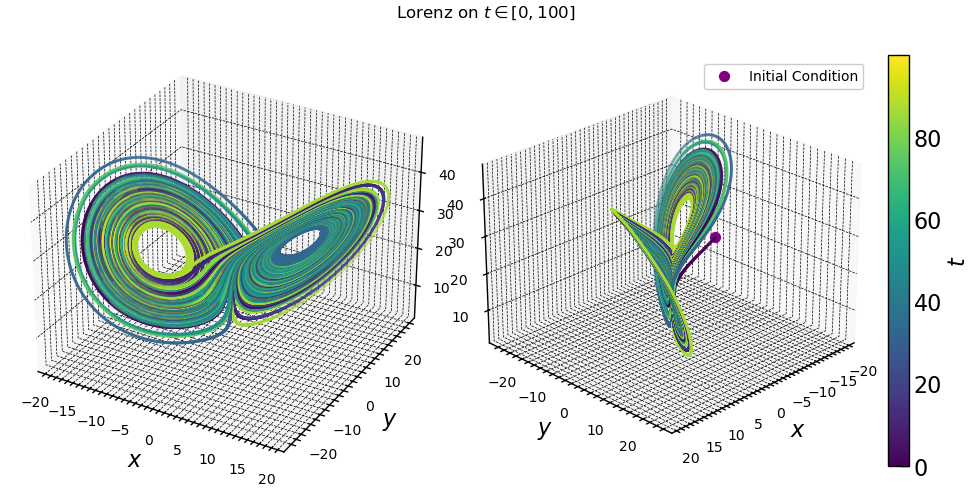

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': '3d'})
scatter1 = axes[0].scatter(x_data, y_data, z_data, c=time, cmap='viridis', marker='.', linewidths=0.0001)
axes[0].set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
axes[0].xaxis.set_tick_params(labelsize=10)
axes[0].yaxis.set_tick_params(labelsize=10)
axes[0].zaxis.set_tick_params(labelsize=10)
scatter2 = axes[1].scatter(x_data, y_data, z_data, c=time, cmap='viridis', marker='.', linewidths=0.0001)
axes[1].scatter(x_data[0], y_data[0], z_data[0], color='purple', s=50, label='Initial Condition')
axes[1].set(xlabel="$x$", ylabel="$y$")
axes[1].xaxis.set_tick_params(labelsize=10)
axes[1].yaxis.set_tick_params(labelsize=10)
axes[1].zaxis.set_tick_params(labelsize=10)
axes[1].legend(prop={'size': 10})
plt.colorbar(scatter2, ax=axes[1], label='$t$', fraction=0.046, pad=0.04)
axes[1].view_init(azim=45, elev=25)
fig.suptitle("Lorenz on $t\in[0,100]$")
plt.tight_layout()
plt.show()

## SINDy

The original paper applies SINDy with the following setting:
- Time series data $\mathbf{X}$ is always available
- The derivatives $\mathbf{X'}$ are either measured or computed numerically
- Clean and noisy derivative $\mathbf{X'}$, with Gaussian noise of variance $\eta=0.01,10$ and zero mean.
- Sequential thresholding for the sparse optimizer, with threshold 0.05
- Polynomial library $\mathbf{\Theta}$ of order 5
- The simulation time is with $t\in[0,20]$.

## $\mathbf{X'}$ measured


In [73]:
xyz_derivative_data = np.array([lorenz(0, xyz_data[t]) for t in range(time.size)]) # X' (no noise)

### Clean Data

In [85]:
feat_names = ["x", "y", "z"]
opt = ps.STLSQ(threshold=0.05)
poly_lib = ps.PolynomialLibrary(degree=5)
short_time = np.arange(0, 20, delta_t) # define simulation time
model1 = ps.SINDy(optimizer=opt, feature_library=poly_lib, feature_names=feat_names) # define model
model1.fit(xyz_data, delta_t, xyz_derivative_data) # determine model

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=PolynomialLibrary(degree=5),
      feature_names=['x', 'y', 'z'], optimizer=STLSQ(threshold=0.05))

In [86]:
model1.print() # print trained model

(x)' = -10.000 x + 10.000 y
(y)' = 28.000 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y


We have identified the coefficients of the model with perfect accuracy. Let's verify it with each coordinate on a shorter time frame with $t\in[0,20]$.

In [87]:
# short_time = np.arange(0,20,delta_t)
# model1_sim = model1.simulate(x0, time[:short_time.size])
model1_sim = model1.simulate(x0, short_time)

In [88]:
model1_sim_x = model1_sim[:, 0]
model1_sim_y = model1_sim[:, 1]
model1_sim_z = model1_sim[:, 2]

In [97]:
def plot_xyz_lorenz(sim_x, sim_y, sim_z, time_limit_size = time.size, x=x_data, y=y_data, z=z_data, title="Clean Data"):
    """
    Plots dynamics of Lorenz in x,y,z

    Args:
        sim_x (_type_): Simulated data for x
        sim_y (_type_): Simulated data for y
        sim_z (_type_): Simulated data for z
        time_limit_size (int): Number of time steps to plot. Defaults to time.size.
        x: True data for x. Defaults to x_data.
        y: True data for y. Defaults to y_data.
        z: True data for z. Defaults to z_data.
        title: part of text to put in the title of the plot
    """
    fig, axes = plt.subplots(3, 1, figsize=(10, 6))

    axes[0].plot(time[:time_limit_size], x[:time_limit_size], label='True')
    axes[0].plot(time[:time_limit_size], sim_x, label='SINDy')
    axes[0].set_ylabel('$x$', fontsize = 15)
    axes[0].legend(loc = "lower right", prop={'size': 10})
    axes[0].xaxis.set_ticklabels([])
    axes[0].yaxis.set_tick_params(labelsize=10)

    axes[1].plot(time[:time_limit_size], y[:time_limit_size])
    axes[1].plot(time[:time_limit_size], sim_y)
    axes[1].set_ylabel('$y$', fontsize = 15)
    axes[1].xaxis.set_ticklabels([])
    axes[1].yaxis.set_tick_params(labelsize=10)

    axes[2].plot(time[:time_limit_size], z[:time_limit_size])
    axes[2].plot(time[:time_limit_size], sim_z)
    axes[2].set_xlabel('$t$', fontsize = 15)
    axes[2].set_ylabel('$z$', fontsize = 15)
    axes[2].xaxis.set_tick_params(labelsize=10)
    axes[2].yaxis.set_tick_params(labelsize=10)
    plt.suptitle(f"True vs SINDy in $(x,y,z)$ for $t\in[0,{int(time_limit_size*delta_t)}]$,  {title}")
    plt.tight_layout()
    plt.show()

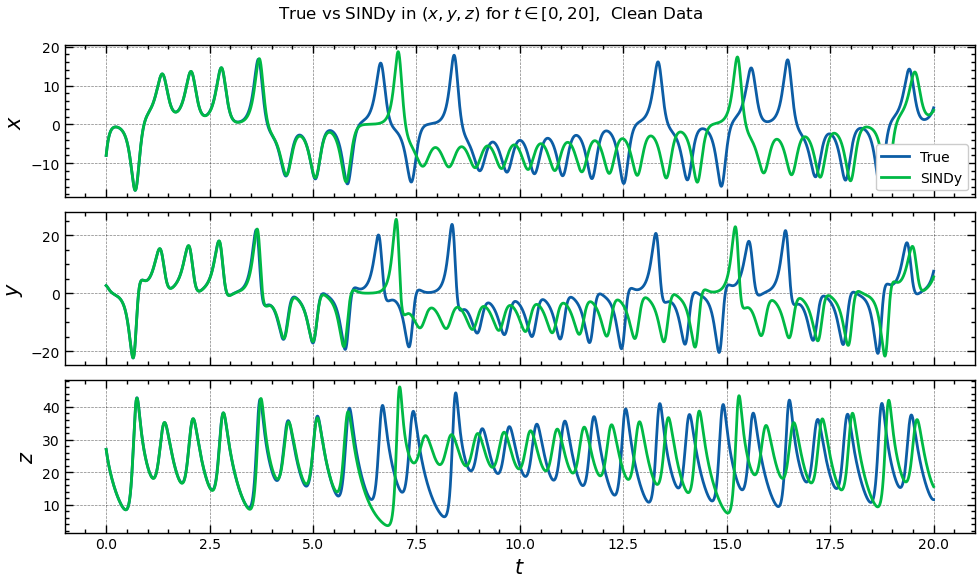

In [98]:
plot_xyz_lorenz(model1_sim_x, model1_sim_y, model1_sim_z, short_time.size)

There is a shift, address it because it shouldn't be there. Maybe it's numerical error (related to floats)?

### Noisy Data

Here the noise is added to the derivative. It is a zero-mean Gaussian noise with variance $\eta\in\{0.01,10\}$. The simulations are done untile time 20.

In [109]:
noises = [0.01, 10]
models = []
models_sim = []

for noise in noises:
    model = ps.SINDy(optimizer=opt, feature_library=poly_lib, feature_names=feat_names)
    model.fit(xyz_data, delta_t, x_dot=xyz_derivative_data + np.random.normal(loc=0.0, scale=noise, size=xyz_data.shape))
    models.append(model)
    models_sim.append(model.simulate(x0, short_time))

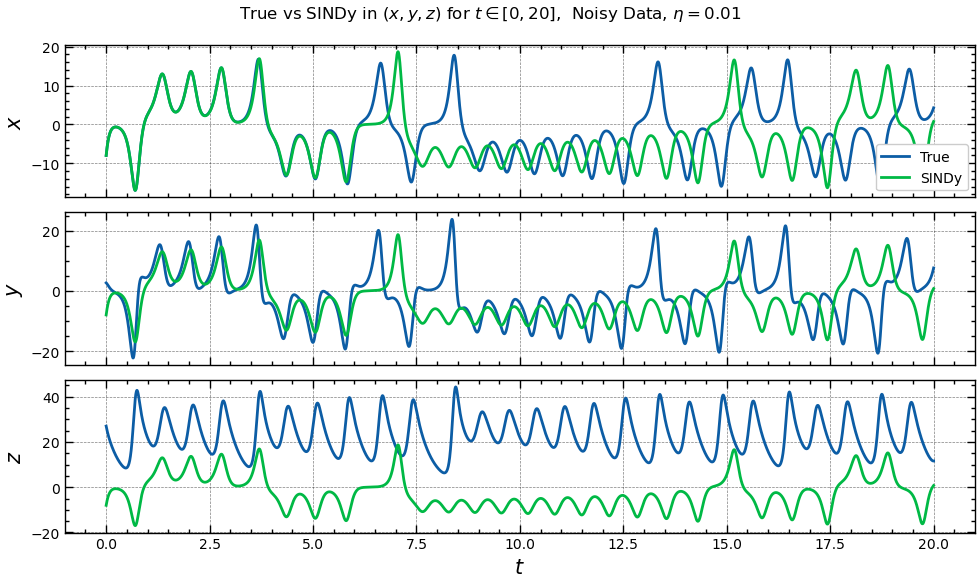

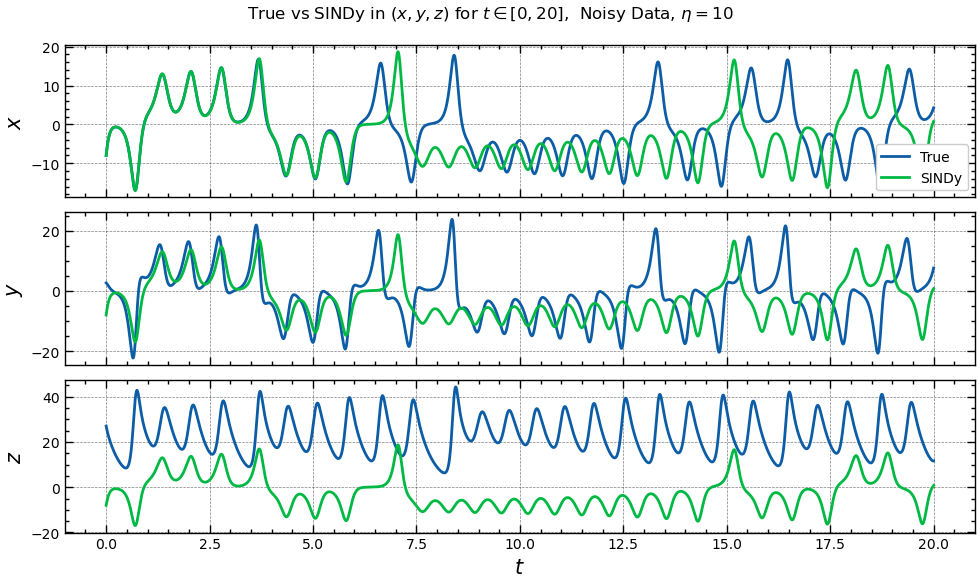

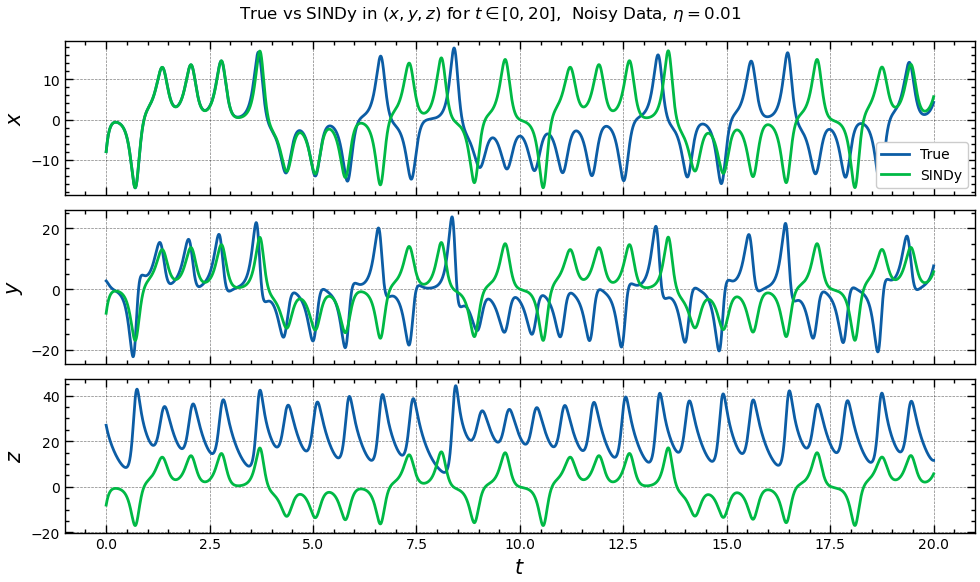

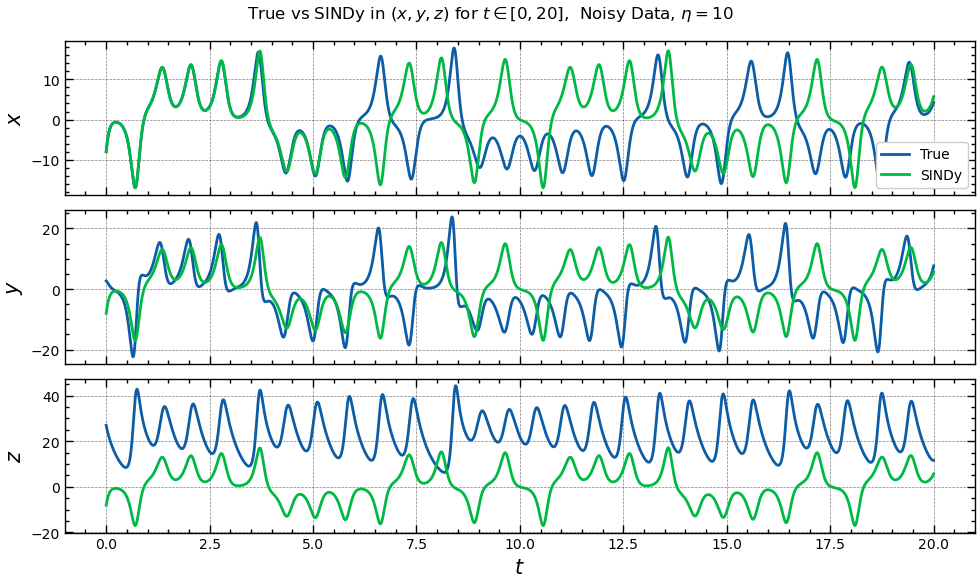

In [113]:
for model_sim in models_sim:
    for noise in noises:
        plot_xyz_lorenz(model_sim[:,0], model_sim[:,0], model_sim[:,0], short_time.size, title=f"Noisy Data, $\eta={noise}$")

I'm doing something wrong...

## $\mathbf{X'}$ calculated

Here the noise is $\eta\in \{0.0001, 0.001, 0.01, 0.1, 1.0, 10.0\}$